In [2]:
# TODO
# - Get a design for the pipeline done, visualized, and prepared. After that, we can have a guided coding session

# - Implement the pipeline in code (Today)
# - Test the pipeline with some sample data (start today)
# - Optimize the pipeline for performance and scalability (next week)

# The pipeline architecture is givern as follows:
# 1. Data Ingestion
#    - Source: CSV files from a specified directory
#    - Source: NoLBERT sentiment
# 2. Data feature engineering
#    - Use LLM to generate features 
#    - Use existing features


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL as pl
import base64
import json
import anthropic
from typing import Generator, Optional


In [2]:
def read_in(path_list, desc_lisc):
    """Batch read-in data files"""
    # the return list of dataframes
    # Key: description of data, Value: data object (e.g., dataframe, image object)
    ret_dict = {}

    for path in path_list:
        if path.endswith('.csv'):
            data_obj = pd.read_csv(path)
            type_obj = 'csv'
        elif path.endswith(('.png', '.jpg', '.jpeg')):
            with open(path, 'rb') as f:
                image = f.read()
                base64_image = base64.b64encode(image).decode('utf-8')
                data_obj = base64_image
                
                # Detect media type
                if path.endswith('.png'):
                    media_type = 'image/png'
                elif path.endswith(('.jpg', '.jpeg')):
                    media_type = 'image/jpeg'
                
                type_obj = 'image'
        else:
            raise ValueError(f"Unsupported file format: {path}")
        ret_dict[desc_lisc[path]] = {'obj':data_obj, 'type':type_obj}

    
    return ret_dict

In [3]:
def prep_FE_payload(max_num_features='10', engineering_goal='default', path_list=[], desc_list={}):
    """Prepare the payload for feature engineering"""
    data_dict = read_in(path_list, desc_list)
    
    # Build the content array for Claude API
    content = []
    
    # Add initial instruction
    goal_text = f"{engineering_goal} Only generate up to {max_num_features} features. Provide code that can be run for each feature in its own method."
    content.append({
        "type": "text",
        "text": goal_text
    })
    
    # Process each data item
    for description, data_info in data_dict.items():
        if data_info['type'] == 'csv':
            # For CSV, include summary instead of full data to manage costs
            df = data_info['obj']
            csv_summary = f"""
Data: {description}
Shape: {df.shape}
Columns: {list(df.columns)}
Data types: {df.dtypes.to_dict()}

Sample data (first 5 rows):
{df.head().to_csv(index=False)}

Basic statistics:
{df.describe().to_dict()}
"""
            content.append({
                "type": "text", 
                "text": csv_summary
            })
            
        elif data_info['type'] == 'image':
            content.append({
                "type": "text",
                "text": f"Image: {description}"
            })
            content.append({
                "type": "image",
                "source": {
                    "type": "base64",
                    "media_type": "image/png",  # You might want to detect this dynamically
                    "data": data_info['obj']
                }
            })
    
    # Count the number of images and csv
    num_images = sum(1 for v in data_dict.values() if v['type'] == 'image')
    num_csv = sum(1 for v in data_dict.values() if v['type'] == 'csv')
    
    # Add final instruction
    content.append({
        "type": "text",
        "text": f"Based on the {num_csv} CSV dataset(s) and {num_images} image(s) provided, generate up to {max_num_features} engineered features. For each feature, provide the implementation code in a separate method."
    })
    
    # Construct the final Claude API payload
    claude_payload = {
        "model": "claude-sonnet-4-20250514",
        "max_tokens": 52000,
        "messages": [
            {
                "role": "user",
                "content": content
            }
        ]
    }
    
    return claude_payload

In [4]:
import anthropic
from typing import Generator, Optional

def send_to_claude(payload: dict, api_key: str, stream: bool = True) -> str:
    """
    Send payload to Claude API with streaming support
    
    Args:
        payload: The Claude API payload from prep_FE_payload()
        api_key: Your Anthropic API key
        stream: Whether to use streaming (default True)
    
    Returns:
        Complete response text from Claude
    """
    client = anthropic.Anthropic(api_key=api_key)
    
    try:
        if stream:
            return _send_with_streaming(client, payload)
        else:
            response = client.messages.create(**payload)
            return response.content[0].text
            
    except anthropic.APIError as e:
        print(f"API Error: {e}")
        raise
    except Exception as e:
        print(f"Unexpected error: {e}")
        raise

def _send_with_streaming(client: anthropic.Anthropic, payload: dict) -> str:
    """Handle streaming response from Claude"""
    # DON'T add stream parameter - the stream() method handles this
    full_response = ""
    
    try:
        with client.messages.stream(**payload) as stream:
            for text in stream.text_stream:
                print(text, end="", flush=True)  # Print as it streams
                full_response += text
                
        print()  # Add newline at the end
        return full_response
        
    except Exception as e:
        print(f"\nStreaming error: {e}")
        raise

def send_to_claude_with_callback(payload: dict, api_key: str, 
                                callback: Optional[callable] = None) -> str:
    """
    Send to Claude with optional callback for each streamed chunk
    
    Args:
        payload: The Claude API payload
        api_key: Your Anthropic API key  
        callback: Optional function to call with each text chunk
        
    Returns:
        Complete response text
    """
    client = anthropic.Anthropic(api_key=api_key)
    
    full_response = ""
    
    try:
        with client.messages.stream(**payload) as stream:
            for text in stream.text_stream:
                full_response += text
                if callback:
                    callback(text)
                else:
                    print(text, end="", flush=True)
                    
        print()  # Add newline
        return full_response
        
    except Exception as e:
        print(f"Error: {e}")
        raise

In [ ]:
# Basic usage
# The data/file directory isnt reachable here, so we extend the directory
extension = '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/'

path_list = []
desc_list = {}

# For each file in the data directory, we need to add it to the path list and desc list
for file in os.listdir(extension+'data/'):
    if file.endswith('csv'):
        if file != 'TSLA_SR.csv':  # Exclude the TSLA_SR.csv file
            path_list.append(extension+'data/'+file)
            desc_list[extension+'data/'+file] = f"A csv containing the price, volume, returns, price adjustment factor, and number of trades for a stock over time."
        else:
            path_list.append(extension+'data/'+file)
            desc_list[extension+'data/'+file] = f"A csv containing the short interest data for Tesla over time."
    elif file.endswith(('png', 'jpg', 'jpeg')):
        path_list.append(extension+'data/'+file)
        desc_list[extension+'data/'+file] = f"An image showing, for a stock, the {" ".join(file.split(sep='_')[2:len(file.split(sep='_'))-1])}" 

response_fmt_str = 'Please format your response as a python script ONLY, with each feature in its own method. Nothing else should be included in the response except at the end a summary of your reasoning from the provided data that made you choose these features.'

print(path_list)
print(desc_list)

payload = prep_FE_payload(
    max_num_features='5',
    engineering_goal='Generate features from the labeled stocks data (both the numerical and image) that might help tell me what function of these stocks will help forecast the short interest change of Tesla over time. The image of this short interest is found in TSLA_Short_Interest.png'+response_fmt_str,
    path_list=path_list,
    desc_list=desc_list
)

response = send_to_claude(payload, api_key, stream=True)
print("Complete response received!")

['/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_86580_return_daily.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_84788_return_daily.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_21413_price.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_19788_number_of_trades_daily.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_14593_return_daily.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_13407_dividend_cash_amount.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_84788_cumulative_price_adjustment_factor.png', '/Users

In [ ]:

# The data/file directory isnt reachable here, so we extend the directory
extension = '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/'

path_list = []
desc_list = {}

stock_dict = {
    '93436': 'Tesla',
    '86580': 'Nvidia',
    '84788': 'Amazon',
    '21413': 'Meta',
    '14593': 'Apple',
    '19788': 'Microsoft',
    '13407': 'Netflix'
}

# For each file in the data directory, we need to add it to the path list and desc list
for file in os.listdir(extension+'data/'):
    if file.endswith('csv'):
        if file != 'TSLA_SR.csv':  # Exclude the TSLA_SR.csv file
            path_list.append(extension+'data/'+file)
            desc_list[extension+'data/'+file] = f"A csv containing the price, volume, returns, price adjustment factor, and number of trades for a stock over time."
        else:
            path_list.append(extension+'data/'+file)
            desc_list[extension+'data/'+file] = f"A csv containing the short interest data for Tesla over time."
    elif file.endswith(('png', 'jpg', 'jpeg')):
        path_list.append(extension+'data/'+file)
        if file != 'TSLA_Short_Interest.png' and file != 'TSLA_Short_Interest_Change.png':
            desc_list[extension+'data/'+file] = f"An image showing, for {stock_dict[file.split('_')[1]]} stock, the {" ".join(file.split(sep='_')[2:len(file.split(sep='_'))-1])}" 
        else:
            desc_list[extension+'data/'+file] = f"An image showing, for Tesla stock, the {" ".join(file.split(sep='_')[1:len(file.split(sep='_'))-1])}"

response_fmt_str = 'Please format your response as a python script ONLY, with each feature in its own method.' \
' Nothing else should be included in the response except at the end a summary of your reasoning from the provided ' \
'data that made you choose these features.'

print(path_list)
print(desc_list)

payload = prep_FE_payload(
    max_num_features='5',
    engineering_goal='Generate features from the labeled stocks data (both the numerical and image) that might help tell me what \
        function of these stocks will help forecast the short interest change of Tesla over time. The image of this short interest is' \
        ' found in TSLA_Short_Interest.png'+response_fmt_str,
    path_list=path_list,
    desc_list=desc_list
)

response = send_to_claude(payload, api_key, stream=True)
print("Complete response received!")

['/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_86580_return_daily.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_84788_return_daily.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_21413_price.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_19788_number_of_trades_daily.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_14593_return_daily.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_13407_dividend_cash_amount.png', '/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/stock_84788_cumulative_price_adjustment_factor.png', '/Users

KeyboardInterrupt: 

In [ ]:
'/Users/joshuachis/Documents/Berkeley MFE/Projects/JPMorgan Industry Project/JPMShortInterest_UCBMFE/data/random_walks/random_walks.csv'

In [24]:
# Now we need to parse the response and extract the script contained in the string returned, write it to a file, and execute the file
def parse_response(resp):
    
    # Find the start of the code block
    code_start = resp.find("```python")
    if code_start == -1:
        code_start = resp.find("```")
    
    if code_start == -1:
        raise ValueError("No code block found in the response.")
    
    # Find the end of the code block
    code_end = resp.find("```", code_start + 3)
    if code_end == -1:
        raise ValueError("No closing code block found in the response.")
    
    # Extract the code
    code = resp[code_start + 10:code_end].strip()  # +7 to skip "```python" or "```"
    
    # Write the code to a .py file
    with open("generated_features.py", "w") as f:
        f.write(code)
    
    print("Code written to generated_features.py")
    
    # Execute the generated script
    import generated_features  # This will run the script and define its functions
    
    print("Script executed. Available functions:")
    print(dir(generated_features))  # List available functions in the module
    
    return generated_features
    

In [25]:
functions = parse_response(response)

Code written to generated_features.py
Script executed. Available functions:
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'feature_price_momentum_divergence', 'feature_price_volatility_rolling', 'feature_relative_sp500_performance', 'feature_trading_intensity_momentum', 'feature_volume_surge_indicator', 'np', 'pd']


Axes(0.125,0.11;0.775x0.77)


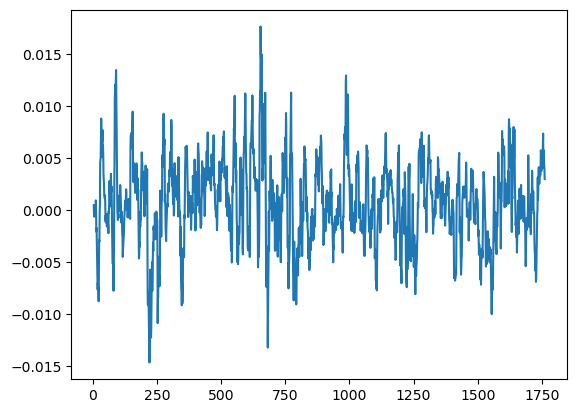

In [ ]:
for path in path_list:
    file = path.split(sep='/')[-1]
    if file != 'TSLA_SR.csv' and file != 'TSLA_base.csv' and file.endswith('.csv'):
        stock_data = pd.read_csv(path)
        test = functions.(stock_data)
print(test.plot())